In [1]:
import os
import sys

projdir = os.path.abspath(os.path.join(os.path.abspath(''), '..'))
sys.path.insert(1, projdir)
os.chdir(projdir)

# 이 셀은 한번만 돌려야함!!
projdir

'/home/maxjo/Projects/ds_pbl'

In [2]:
from utils.DB_connect import get_engine
from sqlalchemy import text
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.seasonal import STL
import re

engine = get_engine(echo=False)

def query(sql):
    with engine.connect() as conn:
        return pd.read_sql(sql, conn)

mpl.rc('font', family='NanumGothic')   # set default font family
mpl.rc('axes', unicode_minus=False)    # ensure minus sign renders

<Axes: title={'center': '2023-01-01 ~ 2024-08-30 지연 횟수 상위 노선'}, xlabel='노선', ylabel='지연 횟수'>

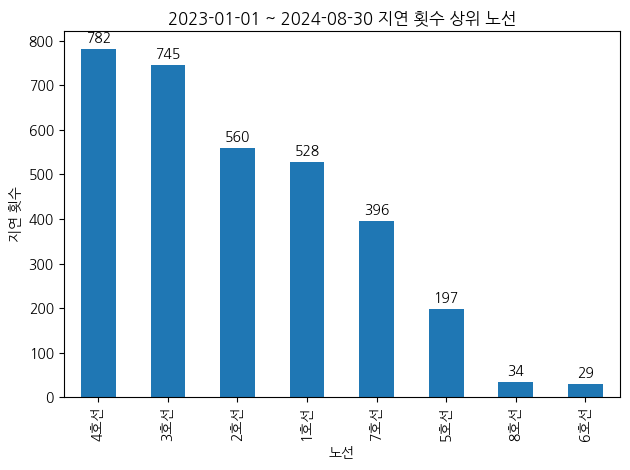

In [3]:
sql = \
"""
select 노선, count(노선) as `지연 횟수` from subway_delays
group by 노선
order by count(노선) desc;
"""
res = query(sql)

date_range = query('select min(지연일자), max(지연일자) from subway_delays')  # 데이터 수집 날짜 찾기
date_range = date_range.values[0][0].strftime('%Y-%m-%d'), date_range.values[0][1].strftime('%Y-%m-%d')

ax = res.plot.bar(x='노선', y='지연 횟수', title=f'{date_range[0]} ~ {date_range[1]} 지연 횟수 상위 노선', xlabel='노선', ylabel='지연 횟수')
ax.bar_label(ax.containers[0], padding=3) # type: ignore
ax.legend().remove()

plt.tight_layout()
ax

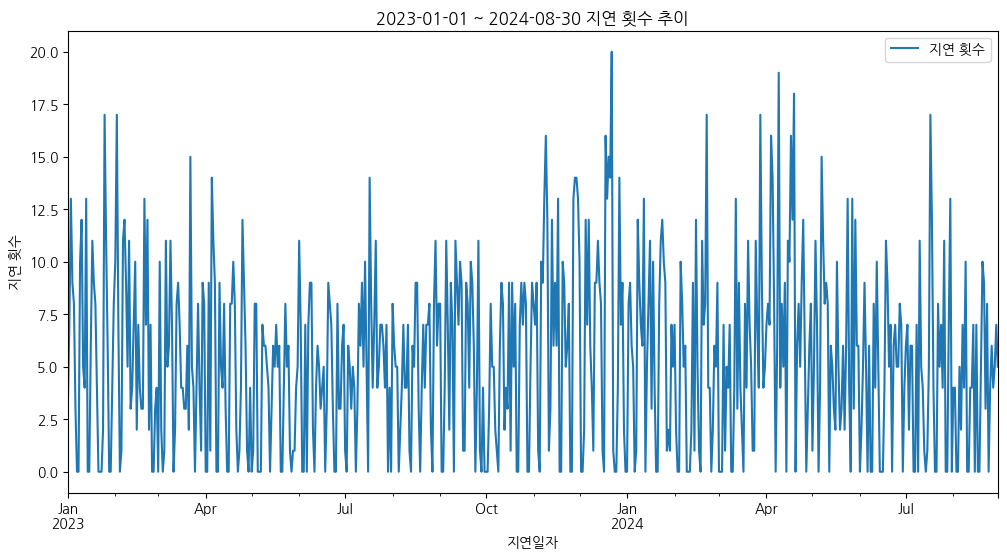

In [4]:
sql = \
"""
select 지연일자, count(노선) as `지연 횟수` from subway_delays
group by 지연일자
order by
    지연일자;
"""
res = query(sql)

res['지연일자'] = pd.to_datetime(res['지연일자'])
res.set_index('지연일자', inplace=True)

# 하루에 1건씩 있도록 만들기, 없으면 0으로 설정
full_idx = pd.date_range(start=res.index.min(),
                         end=res.index.max(),
                         freq='D')
res = res.reindex(full_idx, fill_value=0)
res.index.name = '지연일자'

# reindex the DataFrame and fill missing entries with 0
res = res.reindex(full_idx, fill_value=0)
res.index.name = '지연일자'


ax = res.plot.line(y='지연 횟수', 
                   title=f'{date_range[0]} ~ {date_range[1]} 지연 횟수 추이', 
                   xlabel='지연일자', ylabel='지연 횟수',
                   figsize=(12, 6))

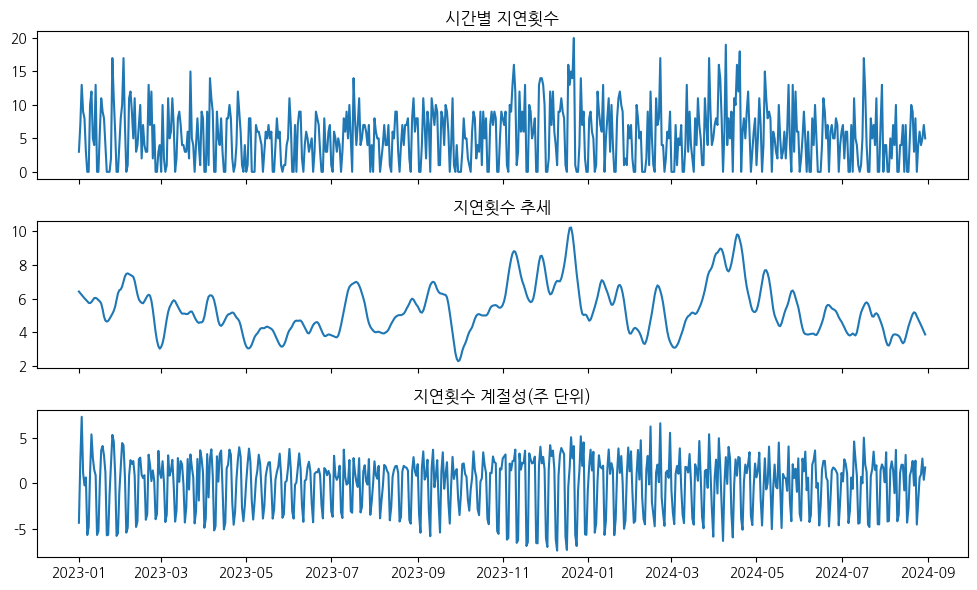

In [5]:
series = res['지연 횟수']
stl = STL(series, period=7)
res = stl.fit()
trend = res.trend
seasonal = res.seasonal
resid = res.resid

fig, axes = plt.subplots(3, 1, figsize=(10, 6), sharex=True)
axes[0].plot(series);      axes[0].set_title('시간별 지연횟수')
axes[1].plot(trend);       axes[1].set_title('지연횟수 추세')
axes[2].plot(seasonal);    axes[2].set_title('지연횟수 계절성(주 단위)')
plt.tight_layout()
plt.show()

주별(주중/주말) seasonal component는 일정하지만,

전반적인 trend는 불규칙한듯이 보인다.

---

In [6]:
sql = \
"""
select 노선, 지연시간대, count(노선) as `지연 횟수` from subway_delays
group by 노선, 지연시간대
order by
    노선,
    지연시간대;
"""
res = query(sql)
res = res.pivot(index='노선', columns='지연시간대', values='지연 횟수').reindex(columns=['첫차~09시', '09시~18시', '18시~막차'])

res

지연시간대,첫차~09시,09시~18시,18시~막차
노선,,,
1호선,424.0,67.0,37.0
2호선,415.0,92.0,53.0
3호선,709.0,36.0,NaN
4호선,729.0,36.0,17.0
5호선,128.0,56.0,13.0
6호선,21.0,7.0,1.0
7호선,211.0,153.0,32.0
8호선,23.0,11.0,NaN


<Axes: title={'center': '노선별 지연 횟수 (시간대별)'}, xlabel='노선', ylabel='지연 횟수'>

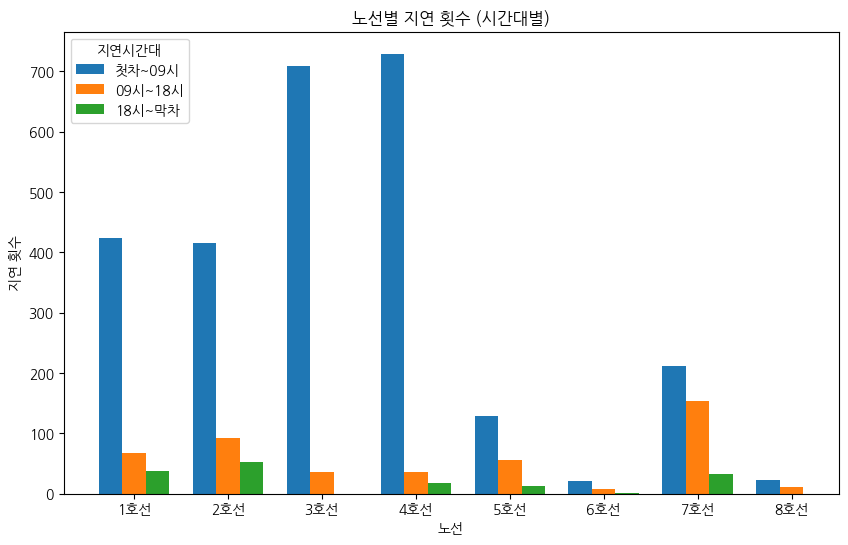

In [7]:
labels = res.index.tolist()
x = np.arange(len(labels))
width = 0.25

fig, ax = plt.subplots(figsize=(10, 6))
for i, slot in enumerate(res.columns):
    ax.bar(x + i*width, res[slot], width, label=slot)

ax.set_xticks(x + width)
ax.set_xticklabels(labels)
ax.set_xlabel('노선')
ax.set_ylabel('지연 횟수')
ax.set_title('노선별 지연 횟수 (시간대별)')
ax.legend(title='지연시간대')

ax

In [8]:
sql = \
"""
select 노선, 요일구분, count(노선) as `지연 횟수` from subway_delays
group by 노선, 요일구분
order by
    노선,
    요일구분;
"""
res = query(sql)
res = res.pivot(index='노선', columns='요일구분', values='지연 횟수').reindex(columns=['평일', '토요일', '일요일'])

res

요일구분,평일,토요일,일요일
노선,,,
1호선,501.0,21.0,6.0
2호선,525.0,28.0,7.0
3호선,699.0,26.0,20.0
4호선,728.0,22.0,32.0
5호선,183.0,2.0,12.0
6호선,28.0,1.0,NaN
7호선,363.0,14.0,19.0
8호선,32.0,NaN,2.0


<Axes: title={'center': '노선별 지연 횟수 (요일별)'}, xlabel='노선', ylabel='지연 횟수'>

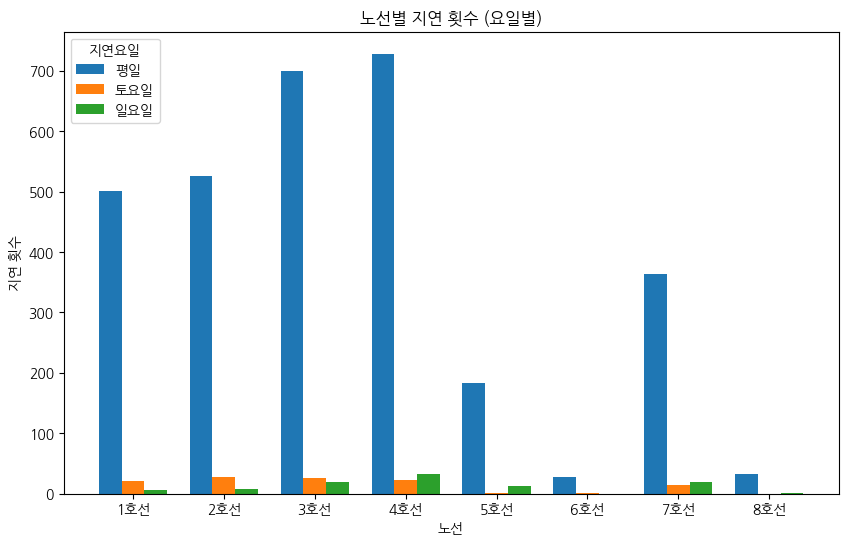

In [9]:
labels = res.index.tolist()
x = np.arange(len(labels))
width = 0.25

fig, ax = plt.subplots(figsize=(10, 6))
for i, slot in enumerate(res.columns):
    ax.bar(x + i*width, res[slot], width, label=slot)

ax.set_xticks(x + width)
ax.set_xticklabels(labels)
ax.set_xlabel('노선')
ax.set_ylabel('지연 횟수')
ax.set_title('노선별 지연 횟수 (요일별)')
ax.legend(title='지연요일')

ax

앞서 추측해본 주별 seasonal component가 있다는것을 컨펌할 수 있다.

---

In [10]:
def plt_bar_delay_time(line: str):
    sql = \
    f"""
    select 노선, 지연시간대, 최대지연시간, count(노선) as `지연 횟수` from subway_delays
    where 노선 = "{line}"
    group by 노선, 지연시간대, 최대지연시간
    order by
        노선,
        지연시간대;
    """
    data = query(sql)
    data = data.pivot(index='지연시간대', columns='최대지연시간', values='지연 횟수')\
        .reindex(columns=[f'{i}분' for i in range(5, 30, 5)] + ['30분 이상']) \
        .reindex(index=['첫차~09시', '09시~18시', '18시~막차'])

    labels = data.index.tolist()
    x = np.arange(len(labels))
    width = 0.1

    fig, ax = plt.subplots(figsize=(10, 6))
    for i, slot in enumerate(data.columns):
        ax.bar(x + i*width, data[slot], width, label=slot, 
               color=['blue', 'green', 'yellow', 'orange', 'red', 'purple'][i % 6])

    ax.set_xticks(x + width)
    ax.set_xticklabels(labels)
    ax.set_xlabel('지연 시간대')
    ax.set_ylabel('지연 횟수')
    ax.set_title(f'{line} 지연 정도 (시간대별)')
    ax.legend(title='지연시간대')

    plt.tight_layout()
    plt.show()

대표적 노선들 지연 정도 확인해보기

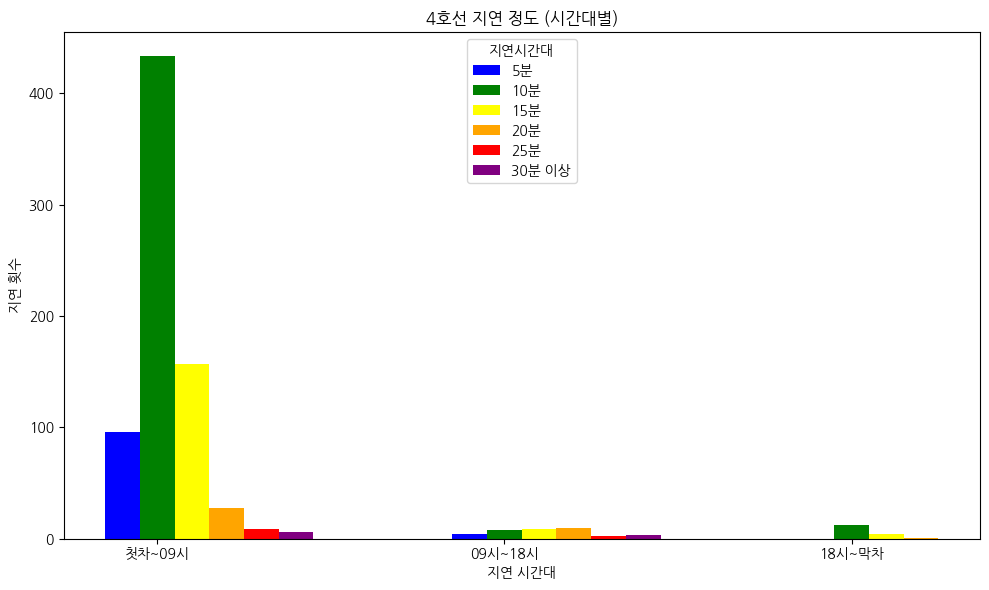

In [11]:
plt_bar_delay_time('4호선')

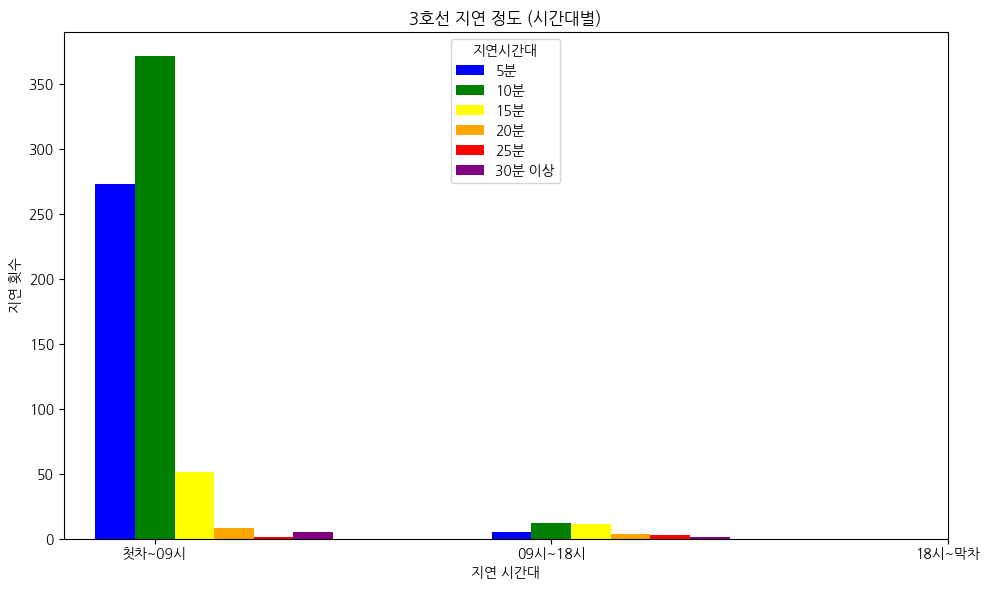

In [12]:
plt_bar_delay_time('3호선')

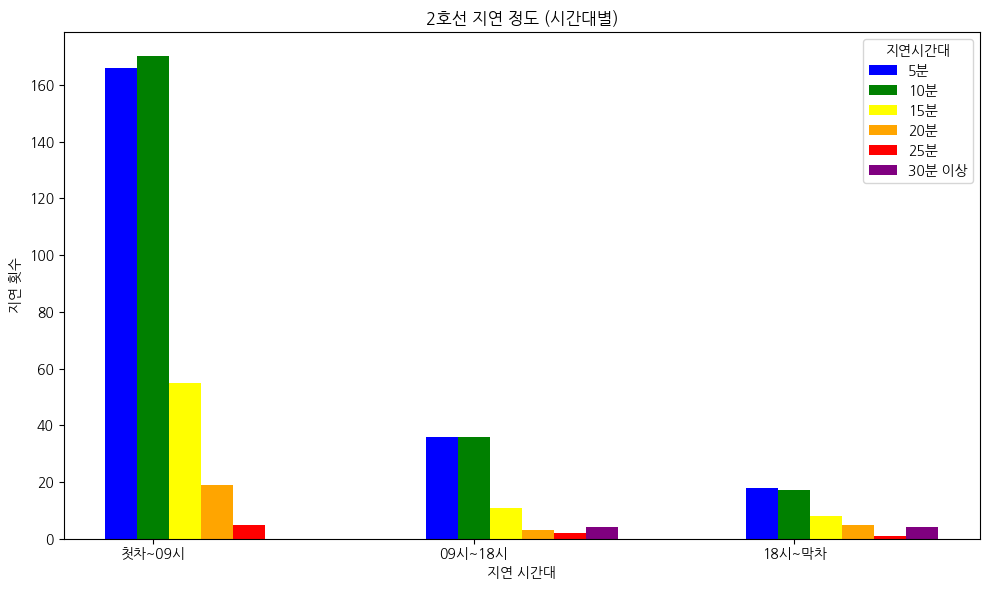

In [13]:
plt_bar_delay_time('2호선')

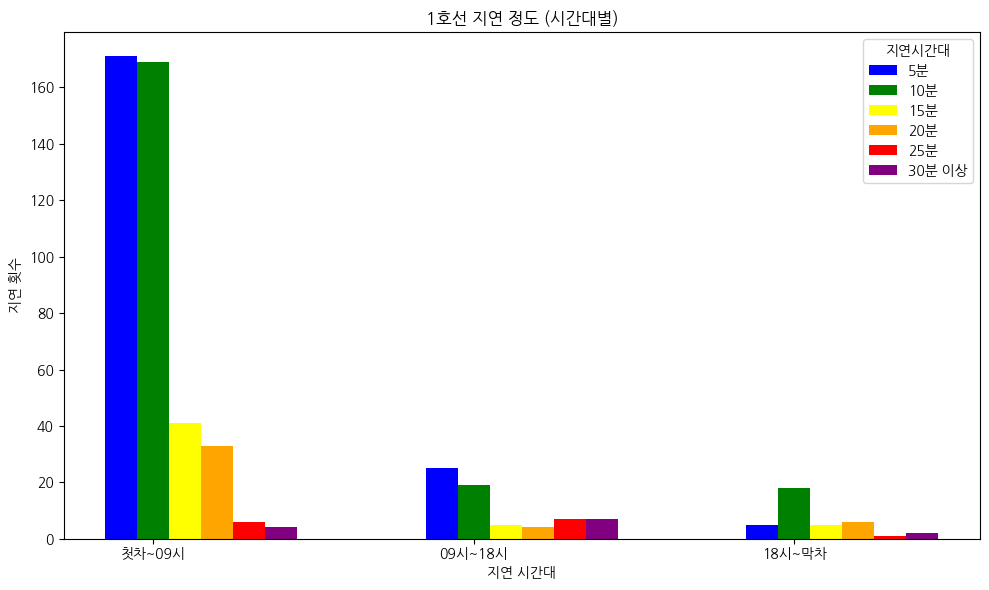

In [14]:
plt_bar_delay_time('1호선')

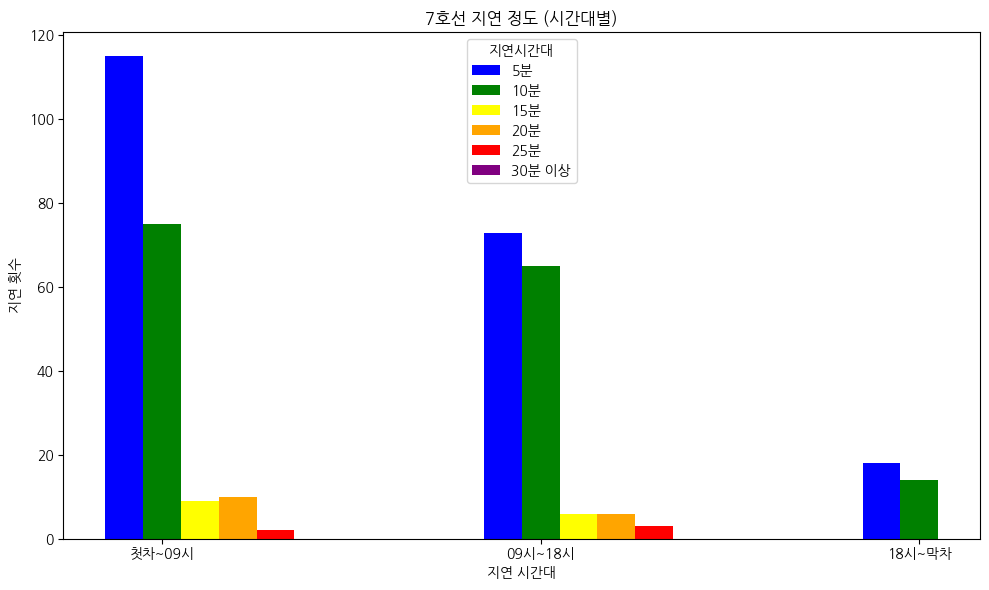

In [15]:
plt_bar_delay_time('7호선')

모든 노선이 아침 출근시간대에 가장 지연이 많음. 7호선은 신기하게도 9~18시 지연 또한 높은 비중을 차지하고 있음.



신도시/위성도시 경기도권까지 가는 1, 3, 4호선이 가장 심한 지연정도를 가지고 있음. 중요 순환선인 2호선 또한 심한 지연을 겪고 있음.

---

In [16]:
# already automated via python
# TODO: clean up to automated SQL query (나중에)

sql = \
"""
select
    노선, 요일구분,
    max(`5시30분`) as `5시30분`,
    max(`6시00분`) as `6시00분`,
    max(`6시30분`) as `6시30분`,
    max(`7시00분`) as `7시00분`,
    max(`7시30분`) as `7시30분`,
    max(`8시00분`) as `8시00분`,
    max(`8시30분`) as `8시30분`,
    max(`9시00분`) as `9시00분`,
    max(`9시30분`) as `9시30분`,
    max(`10시00분`) as `10시00분`,
    max(`10시30분`) as `10시30분`,
    max(`11시00분`) as `11시00분`,
    max(`11시30분`) as `11시30분`,
    max(`12시00분`) as `12시00분`,
    max(`12시30분`) as `12시30분`,
    max(`13시00분`) as `13시00분`,
    max(`13시30분`) as `13시30분`,
    max(`14시00분`) as `14시00분`,
    max(`14시30분`) as `14시30분`,
    max(`15시00분`) as `15시00분`,
    max(`15시30분`) as `15시30분`,
    max(`16시00분`) as `16시00분`,
    max(`16시30분`) as `16시30분`,
    max(`17시00분`) as `17시00분`,
    max(`17시30분`) as `17시30분`,
    max(`18시00분`) as `18시00분`,
    max(`18시30분`) as `18시30분`,
    max(`19시00분`) as `19시00분`,
    max(`19시30분`) as `19시30분`,
    max(`20시00분`) as `20시00분`,
    max(`20시30분`) as `20시30분`,
    max(`21시00분`) as `21시00분`,
    max(`21시30분`) as `21시30분`,
    max(`22시00분`) as `22시00분`,
    max(`22시30분`) as `22시30분`,
    max(`23시00분`) as `23시00분`,
    max(`23시30분`) as `23시30분`,
    max(`00시00분`) as `00시00분`,
    max(`00시30분`) as `00시30분`
from train_congestions
group by 노선, 요일구분;
"""
res = query(sql)

res

,노선,요일구분,5시30분,6시00분,6시30분,7시00분,7시30분,8시00분,8시30분,9시00분,...,20시00분,20시30분,21시00분,21시30분,22시00분,22시30분,23시00분,23시30분,00시00분,00시30분
0,1호선,평일,23.2,22.6,35.3,47.6,72.0,88.6,93.6,69.3,...,40.3,38.1,42.5,37.5,42.4,34.1,32.7,20.4,15.0,2.9
1,2호선,평일,106.9,63.9,66.8,109.7,124.4,145.4,153.6,154.8,...,74.5,81.0,82.4,109.7,108.8,86.2,61.8,38.8,27.8,23.4
2,3호선,평일,49.8,47.2,63.3,94.3,121.8,144.4,115.9,90.2,...,60.1,55.9,52.9,52.3,54.9,58.8,42.3,32.9,32.5,13.4
3,4호선,평일,78.0,49.5,60.4,100.9,128.2,166.2,145.0,113.8,...,60.1,76.3,55.8,50.9,72.1,83.7,59.1,46.4,25.0,18.2
4,5호선,평일,54.2,57.0,75.6,92.3,124.1,130.9,116.3,114.4,...,83.4,77.8,70.5,71.8,69.2,67.2,54.1,40.6,28.9,23.9
5,6호선,평일,43.0,34.2,45.0,78.3,87.5,111.6,93.8,86.9,...,51.7,47.3,52.0,49.5,56.2,51.0,37.6,24.5,16.4,11.9
6,7호선,평일,121.2,78.3,83.9,126.6,147.0,145.1,132.9,138.4,...,82.1,76.7,88.1,89.0,92.4,80.1,52.6,52.5,41.2,20.7
7,8호선,평일,49.2,63.9,84.3,96.7,136.4,143.0,147.9,116.6,...,71.1,70.9,76.0,80.7,83.5,85.7,66.6,42.7,31.7,14.4
8,1호선,토요일,17.2,43.8,19.5,15.7,25.3,35.7,29.3,34.4,...,45.7,39.7,40.3,42.1,44.9,30.9,36.3,28.6,23.0,0.0
9,2호선,토요일,73.5,42.8,40.4,37.3,43.7,63.0,75.7,79.5,...,74.1,76.8,79.9,81.6,91.7,92.1,83.9,89.8,0.0,0.0


In [17]:
def parse_time(col):
    m = re.match(r"(\d{1,2})시(\d{2})분", col)
    if not m:
        return None
    h, mi = map(int, m.groups())
    # treat "00시XX분" as hour=24 for grouping wrap-around
    if h == 0:
        h = 24
    return h + mi/60

time_map = {col: parse_time(col) for col in res.columns}

period_map = {}
for col, t in time_map.items():
    if t is None:
        continue
    if 5.5 <= t <= 8.5:              # 05:30–08:30
        period_map[col] = "첫차~09시"
    elif 9.0 <= t <= 17.5:           # 09:00–17:30
        period_map[col] = "09시~18시"
    else:                            # 18:00–24:30 (00:30 -> 24.5)
        period_map[col] = "18시~막차"

# 앞에서 만든 period_map 기준으로 aggregate (MAX 사용)
agg = res[list(period_map)].groupby(period_map, axis=1).max() # type: ignore

subway_congestion = pd.concat([res[['노선', '요일구분']], agg], axis=1)
subway_congestion


/tmp/ipykernel_423704/293910049.py:25: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  agg = res[list(period_map)].groupby(period_map, axis=1).max() # type: ignore


,노선,요일구분,09시~18시,18시~막차,첫차~09시
0,1호선,평일,77.1,125.3,93.6
1,2호선,평일,154.8,144.4,153.6
2,3호선,평일,109.1,122.9,144.4
3,4호선,평일,128.4,146.4,166.2
4,5호선,평일,132.3,128.0,130.9
5,6호선,평일,90.3,122.8,111.6
6,7호선,평일,138.4,157.0,147.0
7,8호선,평일,119.0,137.8,147.9
8,1호선,토요일,66.5,64.9,43.8
9,2호선,토요일,96.0,92.1,75.7


In [18]:
sql = \
"""
select 노선, 요일구분, 지연시간대 from subway_delays
"""
delay_times = query(sql)
delay_times

,노선,요일구분,지연시간대
0,7호선,일요일,09시~18시
1,7호선,일요일,09시~18시
2,7호선,일요일,09시~18시
3,2호선,평일,첫차~09시
4,7호선,평일,18시~막차
...,...,...,...
3266,4호선,평일,첫차~09시
3267,4호선,평일,첫차~09시
3268,3호선,평일,첫차~09시
3269,3호선,평일,첫차~09시


---

merging

In [ ]:
delay_counts = (
    delay_times
    .groupby(['노선', '요일구분', '지연시간대'])
    .size()
    .reset_index(name='지연횟수')
) # type: ignore

# subway_congestion과 같이 3넓이 형태로 변환
delay_pivot = (
    delay_counts
    .pivot(index=['노선', '요일구분'],
           columns='지연시간대',
           values='지연횟수')
    .reset_index()
    .rename_axis(None, axis=1)
    .fillna(0)  # no delays → zero
)

delay_pivot.rename(columns={
    '09시~18시': '09시~18시 지연횟수',
    '첫차~09시': '첫차~09시 지연횟수',
    '18시~막차': '18시~막차 지연횟수'
}, inplace=True)

In [20]:
merged = pd.merge(
    subway_congestion,
    delay_pivot,
    on=['노선', '요일구분'],
    how='left'
).fillna(0)

merged.to_csv('./data/subway_congestion_delays.csv', index=False)

merged

,노선,요일구분,09시~18시,18시~막차,첫차~09시,09시~18시 지연횟수,18시~막차 지연횟수,첫차~09시 지연횟수
0,1호선,평일,77.1,125.3,93.6,52.0,29.0,420.0
1,2호선,평일,154.8,144.4,153.6,73.0,41.0,411.0
2,3호선,평일,109.1,122.9,144.4,35.0,0.0,664.0
3,4호선,평일,128.4,146.4,166.2,32.0,13.0,683.0
4,5호선,평일,132.3,128.0,130.9,48.0,8.0,127.0
5,6호선,평일,90.3,122.8,111.6,7.0,0.0,21.0
6,7호선,평일,138.4,157.0,147.0,135.0,26.0,202.0
7,8호선,평일,119.0,137.8,147.9,9.0,0.0,23.0
8,1호선,토요일,66.5,64.9,43.8,11.0,6.0,4.0
9,2호선,토요일,96.0,92.1,75.7,14.0,12.0,2.0


In [21]:
slots = ['09시~18시', '18시~막차', '첫차~09시']
for slot in slots:
    cong = merged[slot]  # congestion level (%)
    delay = merged[f'{slot} 지연횟수']  # delay count
    r = cong.corr(delay)  # Pearson’s r
    print(f'{slot} correlation: {r:.2f}')

09시~18시 correlation: 0.57
18시~막차 correlation: 0.33
첫차~09시 correlation: 0.72


In [22]:
# reshape to one row per (line, day, slot)
long = merged.melt(
    id_vars=['노선', '요일구분'],
    value_vars=slots,
    var_name='시간대',
    value_name='혼잡도'
).merge(
    merged.melt(
        id_vars=['노선', '요일구분'],
        value_vars=[f'{s} 지연횟수' for s in slots],
        var_name='시간대_지연',
        value_name='지연횟수'
    ),
    left_on=['노선','요일구분','시간대'],
    right_on=['노선','요일구분', '시간대_지연']
)
overall_r = long['혼잡도'].corr(long['지연횟수'])
print(f'Overall congestion–delay correlation: {overall_r:.2f}')


Overall congestion–delay correlation: nan


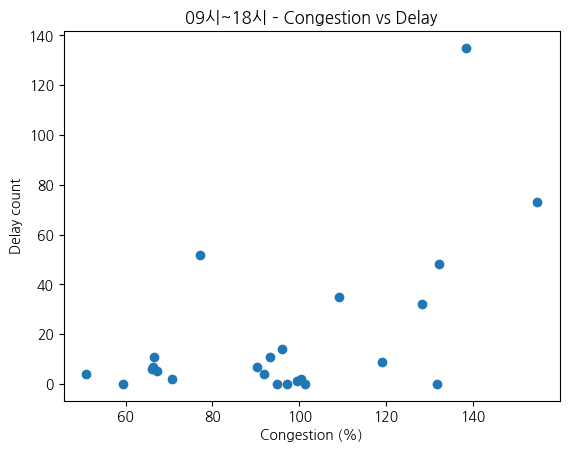

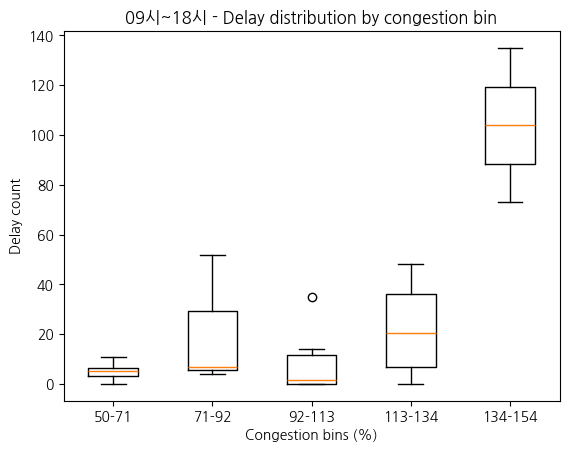

In [23]:
slot = '09시~18시'
cong = merged[slot]
delay = merged[f'{slot} 지연횟수']

# catter plot
fig, ax = plt.subplots()
ax.scatter(cong, delay)
ax.set_xlabel('Congestion (%)')
ax.set_ylabel('Delay count')
ax.set_title(f'{slot} – Congestion vs Delay')
plt.show()

# boxplot
bins = np.linspace(cong.min(), cong.max(), 6)
labels = [f"{int(bins[i])}-{int(bins[i+1])}" for i in range(len(bins)-1)]
merged['cong_bin'] = pd.cut(cong, bins=bins, labels=labels, include_lowest=True)

data = [delay[merged['cong_bin'] == label] for label in labels]
fig, ax = plt.subplots()
ax.boxplot(data, tick_labels=labels)
ax.set_xlabel('Congestion bins (%)')
ax.set_ylabel('Delay count')
ax.set_title(f'{slot} - Delay distribution by congestion bin')
plt.show()


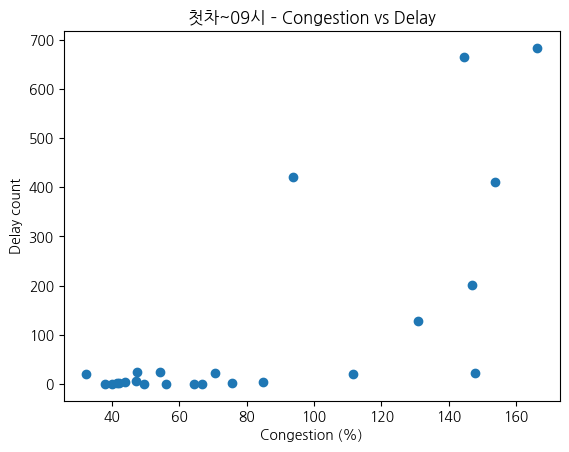

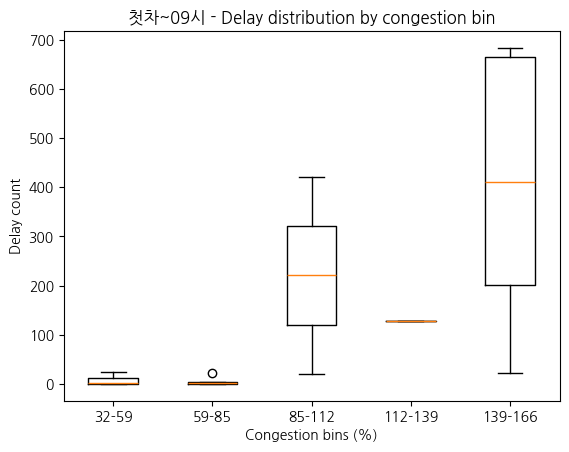

In [24]:
slot = '첫차~09시'
cong = merged[slot]
delay = merged[f'{slot} 지연횟수']

# catter plot
fig, ax = plt.subplots()
ax.scatter(cong, delay)
ax.set_xlabel('Congestion (%)')
ax.set_ylabel('Delay count')
ax.set_title(f'{slot} – Congestion vs Delay')
plt.show()

# boxplot
bins = np.linspace(cong.min(), cong.max(), 6)
labels = [f"{int(bins[i])}-{int(bins[i+1])}" for i in range(len(bins)-1)]
merged['cong_bin'] = pd.cut(cong, bins=bins, labels=labels, include_lowest=True)

data = [delay[merged['cong_bin'] == label] for label in labels]
fig, ax = plt.subplots()
ax.boxplot(data, tick_labels=labels)
ax.set_xlabel('Congestion bins (%)')
ax.set_ylabel('Delay count')
ax.set_title(f'{slot} - Delay distribution by congestion bin')
plt.show()

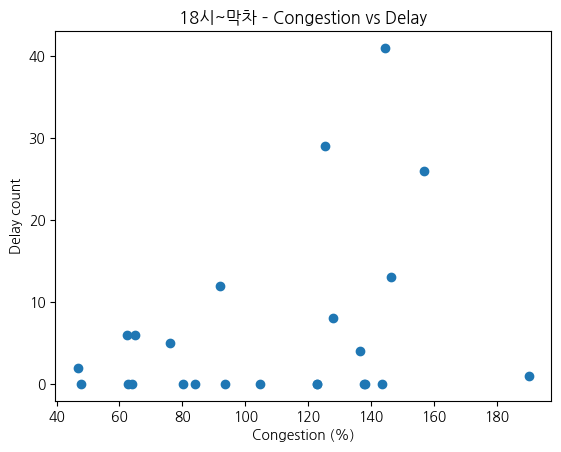

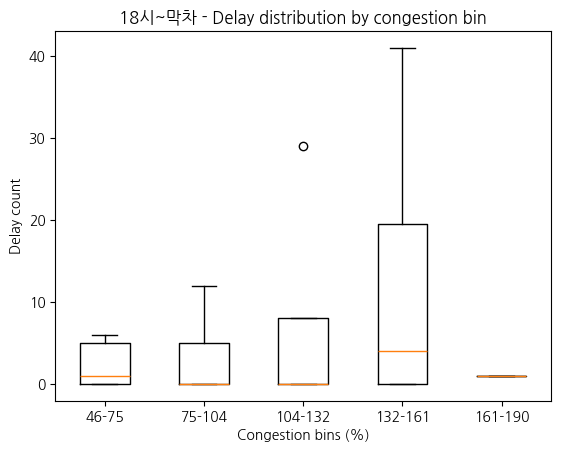

In [25]:
slot = '18시~막차'
cong = merged[slot]
delay = merged[f'{slot} 지연횟수']

# catter plot
fig, ax = plt.subplots()
ax.scatter(cong, delay)
ax.set_xlabel('Congestion (%)')
ax.set_ylabel('Delay count')
ax.set_title(f'{slot} – Congestion vs Delay')
plt.show()

# boxplot
bins = np.linspace(cong.min(), cong.max(), 6)
labels = [f"{int(bins[i])}-{int(bins[i+1])}" for i in range(len(bins)-1)]
merged['cong_bin'] = pd.cut(cong, bins=bins, labels=labels, include_lowest=True)

data = [delay[merged['cong_bin'] == label] for label in labels]
fig, ax = plt.subplots()
ax.boxplot(data, tick_labels=labels)
ax.set_xlabel('Congestion bins (%)')
ax.set_ylabel('Delay count')
ax.set_title(f'{slot} - Delay distribution by congestion bin')
plt.show()

---

지연시간 보존하여 분석

In [26]:
sql = \
"""
select 노선, 요일구분, 지연시간대, 최대지연시간 from subway_delays
"""
delay_times = query(sql)
delay_times

,노선,요일구분,지연시간대,최대지연시간
0,7호선,일요일,09시~18시,5분
1,7호선,일요일,09시~18시,5분
2,7호선,일요일,09시~18시,5분
3,2호선,평일,첫차~09시,20분
4,7호선,평일,18시~막차,5분
...,...,...,...,...
3266,4호선,평일,첫차~09시,10분
3267,4호선,평일,첫차~09시,10분
3268,3호선,평일,첫차~09시,10분
3269,3호선,평일,첫차~09시,5분


In [27]:
# assume delay_times is your second DataFrame
delay_counts = (
    delay_times
    .groupby(['노선', '요일구분', '지연시간대'])
    .size()
    .reset_index(name='delay_count')
)

cong_long = subway_congestion.melt(
    id_vars=['노선', '요일구분'],
    value_vars=['09시~18시', '18시~막차', '첫차~09시'],
    var_name='지연시간대',
    value_name='congestion'
)

cong_long

,노선,요일구분,지연시간대,congestion
0,1호선,평일,09시~18시,77.1
1,2호선,평일,09시~18시,154.8
2,3호선,평일,09시~18시,109.1
3,4호선,평일,09시~18시,128.4
4,5호선,평일,09시~18시,132.3
...,...,...,...,...
67,4호선,일요일,첫차~09시,47.5
68,5호선,일요일,첫차~09시,41.5
69,6호선,일요일,첫차~09시,55.9
70,7호선,일요일,첫차~09시,47.0


In [28]:
merged = cong_long.merge(
    delay_counts,
    on=['노선', '요일구분', '지연시간대'],
    how='left'
).fillna({'delay_count': 0})

merged


,노선,요일구분,지연시간대,congestion,delay_count
0,1호선,평일,09시~18시,77.1,52.0
1,2호선,평일,09시~18시,154.8,73.0
2,3호선,평일,09시~18시,109.1,35.0
3,4호선,평일,09시~18시,128.4,32.0
4,5호선,평일,09시~18시,132.3,48.0
...,...,...,...,...,...
67,4호선,일요일,첫차~09시,47.5,24.0
68,5호선,일요일,첫차~09시,41.5,1.0
69,6호선,일요일,첫차~09시,55.9,0.0
70,7호선,일요일,첫차~09시,47.0,6.0


In [29]:
cong_long = subway_congestion.melt(
    id_vars=['노선', '요일구분'],
    value_vars=['09시~18시', '18시~막차', '첫차~09시'],
    var_name='지연시간대',
    value_name='congestion'
)

delay_times['max_delay_min'] = (
    delay_times['최대지연시간']
    .str.replace('분','').str.replace('이상', '')
    .astype(int)
)

events = delay_times.merge(
    cong_long,
    on=['노선', '요일구분', '지연시간대'],
    how='left'
)

events.drop(columns=['최대지연시간'], inplace=True)

In [30]:
events

,노선,요일구분,지연시간대,max_delay_min,congestion
0,7호선,일요일,09시~18시,5,66.4
1,7호선,일요일,09시~18시,5,66.4
2,7호선,일요일,09시~18시,5,66.4
3,2호선,평일,첫차~09시,20,153.6
4,7호선,평일,18시~막차,5,157.0
...,...,...,...,...,...
3266,4호선,평일,첫차~09시,10,166.2
3267,4호선,평일,첫차~09시,10,166.2
3268,3호선,평일,첫차~09시,10,144.4
3269,3호선,평일,첫차~09시,5,144.4


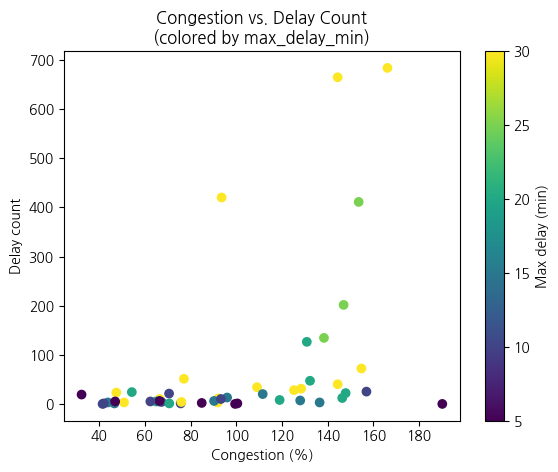

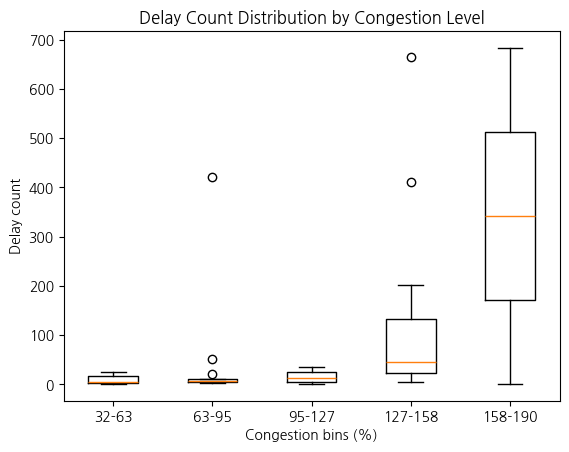

In [31]:
# Aggregate into one row per (노선, 요일구분, 지연시간대 기준준)
agg = (
    events
    .groupby(['노선', '요일구분', '지연시간대'])
    .agg(
        delay_count=('max_delay_min', 'size'),
        max_delay_min=('max_delay_min', 'max'),
        congestion=('congestion', 'first')
    )
    .reset_index()
)

# scatter plot
plt.figure()
sc = plt.scatter(
    agg['congestion'],
    agg['delay_count'],
    c=agg['max_delay_min']
)
plt.colorbar(sc, label='Max delay (min)')
plt.xlabel('Congestion (%)')
plt.ylabel('Delay count')
plt.title('Congestion vs. Delay Count\n(colored by max_delay_min)')
plt.show()

# Boxplot
bins = np.linspace(agg['congestion'].min(), agg['congestion'].max(), 6)
labels = [f"{int(bins[i])}-{int(bins[i+1])}" for i in range(len(bins)-1)]
agg['cong_bin'] = pd.cut(agg['congestion'], bins=bins, labels=labels, include_lowest=True)

data = [agg.loc[agg['cong_bin'] == lab, 'delay_count'] for lab in labels]
plt.figure()
plt.boxplot(data, tick_labels=labels)
plt.xlabel('Congestion bins (%)')
plt.ylabel('Delay count')
plt.title('Delay Count Distribution by Congestion Level')
plt.show()